In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

In [13]:
path = '/content/drive/My Drive/UEPG/eng-comp/5-ano/tcc-v2/FER/'


In [14]:
pd.options.mode.chained_assignment = None

In [15]:
dataset = pd.read_csv(path + "fer2013.csv")

train = dataset[dataset["Usage"] == "Training"]

test = dataset[dataset["Usage"] == "PublicTest"]

train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

In [16]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [17]:
dataset[dataset['emotion'] == 1].head()

,emotion,pixels,Usage
299,1,126 126 129 120 110 168 174 172 173 174 170 15...,Training
388,1,89 55 24 40 43 48 53 55 59 41 33 31 22 32 42 4...,Training
416,1,204 195 181 131 50 50 57 56 66 98 138 161 173 ...,Training
473,1,14 11 13 12 41 95 113 112 111 122 132 137 142 ...,Training
533,1,18 25 49 75 89 97 100 100 101 103 105 107 107 ...,Training


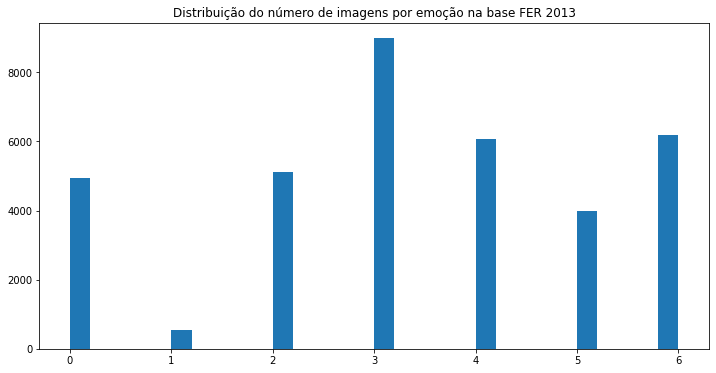

In [19]:
plt.figure(figsize=(12,6))
plt.hist(dataset['emotion'], bins=30)
plt.title("Distribuição do número de imagens por emoção na base FER 2013")
plt.show()

In [20]:
train.shape

(28709, 3)

In [21]:
test.shape

(3589, 3)

In [22]:
shape_x = 48
shape_y = 48

In [23]:
X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

#np.vstack stack arrays in sequence vertically (picking element row wise)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

#Reshape X_train, y_train,X_test,y_test in desired formats
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

print("O shape de X_train e y_train é " + str(X_train.shape) +" and " + str(y_train.shape) +" respectivamente.")
print("O shape de X_test e y_test é " + str(X_test.shape) +" and " + str(y_test.shape) +" respectivamente.")

O shape de X_train e y_train é (28709, 48, 48, 1) and (28709, 1) respectivamente.
O shape de X_test e y_test é (3589, 48, 48, 1) and (3589, 1) respectivamente.


In [24]:
# Change to float datatype
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')

# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

In [25]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)

Total number of outputs :  7
Output classes :  [0 1 2 3 4 5 6]


In [26]:
#Defining labels 
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

In [28]:
def get_portuguese_label(argument):
    labels = {0:'Raiva', 1:'Desgosto', 2:'Medo', 3:'Felicidade', 4:'Tristeza' , 5:'Surpresa', 6:'Calma'}
    return(labels.get(argument, "Invalid emotion"))  

Text(0.5, 1.0, 'Emoção : Surpresa')

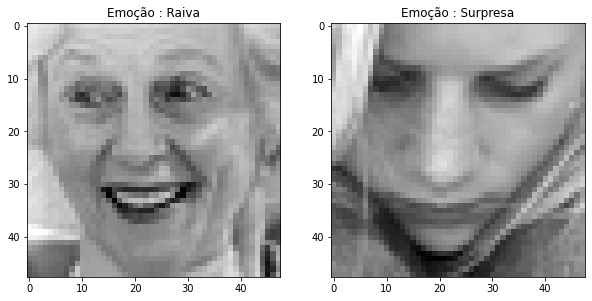

In [29]:
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(np.squeeze(X_train[25,:,:], axis = 2), cmap='gray')
plt.title("Emoção : {}".format(get_portuguese_label(int(y_train[0]))))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(np.squeeze(X_test[26,:,:], axis = 2), cmap='gray')
plt.title("Emoção : {}".format(get_portuguese_label(int(y_test[1500]))))

# Detect faces

Utilização do classificador do OpenCV (faceCascade). A detecção de objetos usando classificadores em cascata é um método eficas proposto por Paul viola e Michael Jones no artigo "Rapid Detection using a boosted cascade classifier of simple features", de 2001. É uma abordagem baseada em machine learning, treinada com várias imagens e posteriormente utilizada para detectar objetos em outras imagens.

In [31]:
def detect_face(frame):
    
    #Cascade classifier pre-trained model
    cascPath = '/content/drive/My Drive/UEPG/eng-comp/5-ano/tcc-v2/FER/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []
    
    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            #cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 255,255),1)
            coord.append([x,y,w,h])
    
    return gray, detected_faces, coord

In [32]:
#Extraire les features faciales
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]
    
    new_face = []
    
    for det in detected_face :
        #Region dans laquelle la face est détectée
        x, y, w, h = det
        #X et y correspondent à la conversion en gris par gray, et w, h correspondent à la hauteur/largeur
    
        #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #gray transforme l'image
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
    
        #Zoom sur la face extraite
        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
        #cast type float
        new_extracted_face = new_extracted_face.astype(np.float32)
        #scale
        new_extracted_face /= float(new_extracted_face.max())
        #print(new_extracted_face)
    
        new_face.append(new_extracted_face)
    
    return new_face


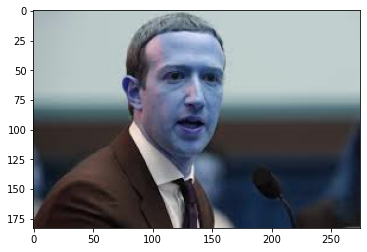

In [33]:
mark = '/content/drive/My Drive/UEPG/eng-comp/5-ano/tcc-v2/FER/images/mark.jpeg'
mark_face = cv2.imread(mark, cv2.COLOR_BGR2RGB)
plt.imshow(mark_face)

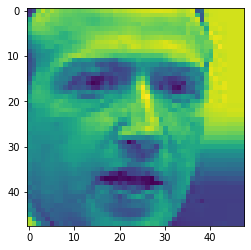

In [35]:
face = extract_face_features(detect_face(mark_face))[0]
plt.imshow(face)

# Xception


In [36]:
  def entry_flow(inputs):
    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in [128, 256, 728] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

In [37]:

def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    return x

In [38]:
def exit_flow(x, num_classes=7) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
      
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    return x

In [39]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

In [40]:
xception = Model(inputs, outputs)

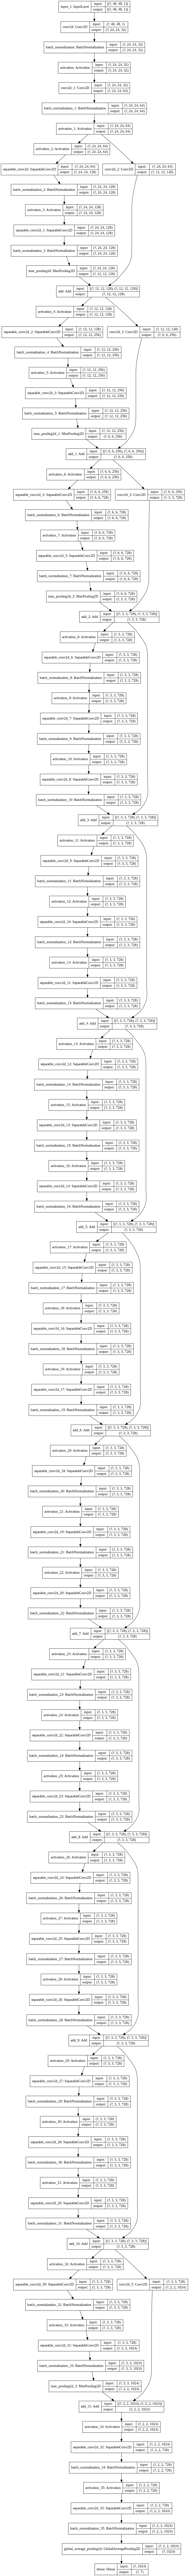

In [41]:
plot_model(xception, to_file='/content/drive/My Drive/UEPG/eng-comp/5-ano/tcc-v2/FER/xception/model_images/model.png', show_shapes=True, show_layer_names=True)

In [42]:
xception.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 24, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 24, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [44]:
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 150

In [46]:
datagen = ImageDataGenerator(
      zoom_range=0.2,          # randomly zoom into images
      rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
      width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
      height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
      horizontal_flip=True,    # randomly flip images
      vertical_flip=False      # randomly flip images 
)

In [47]:
history = xception.fit_generator(
    datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
    epochs = epochs, 
    validation_data=(test_data, test_labels_one_hot)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
225/225 [==============================] - 26s 118ms/step - loss: 1.6502 - accuracy: 0.3508 - val_loss: 1.8458 - val_accuracy: 0.1819
Epoch 2/150
225/225 [==============================] - 26s 114ms/step - loss: 1.4195 - accuracy: 0.4557 - val_loss: 2.1745 - val_accuracy: 0.1819
Epoch 3/150
225/225 [==============================] - 26s 118ms/step - loss: 1.3003 - accuracy: 0.5068 - val_loss: 2.2064 - val_accuracy: 0.3112
Epoch 4/150
225/225 [==============================] - 26s 116ms/step - loss: 1.2411 - accuracy: 0.5278 - val_loss: 3.8385 - val_accuracy: 0.2171
Epoch 5/150
225/225 [==============================] - 26s 116ms/step - loss: 1.1903 - accuracy: 0.5487 - val_loss: 3.9741 - val_accuracy: 0.3608
Epoch 6/150
225/225 [==============================] - 26s 116ms/step - loss: 1.1657 - accuracy: 0.5596 - val_loss: 2.9810 - val_accuracy: 0.4826
Epoch 7/150
225/225 [===========================

In [49]:
json_string = xception.to_json()
xception.save_weights('/content/drive/My Drive/UEPG/eng-comp/5-ano/tcc-v2/FER/xception/model-xception-weights.h5')

In [50]:
open('/content/drive/My Drive/UEPG/eng-comp/5-ano/tcc-v2/FER/xception/xception.json', 'w').write(json_string)

72163

Text(0.5, 1.0, 'Accuracy Curves')

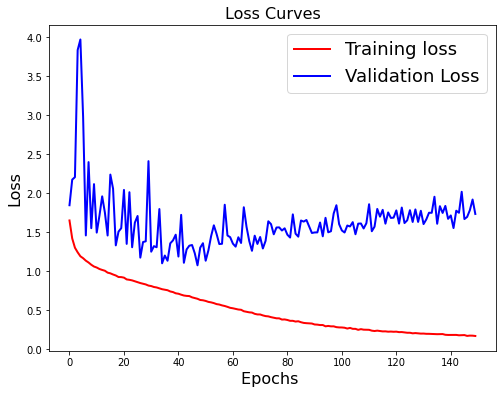

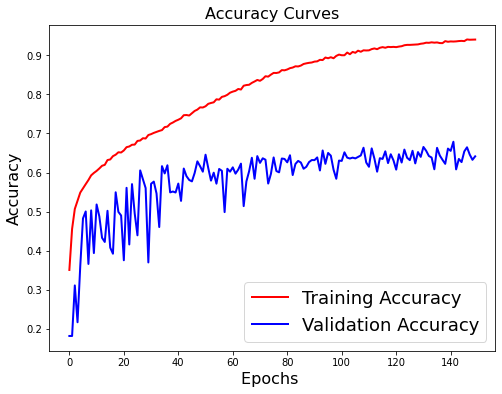

In [51]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [55]:
history.history['val_accuracy']

[0.1819448322057724,
 0.1819448322057724,
 0.31122875213623047,
 0.21705210208892822,
 0.36082473397254944,
 0.4825856685638428,
 0.500417947769165,
 0.3661186993122101,
 0.5032042264938354,
 0.39398160576820374,
 0.5182502269744873,
 0.4878796339035034,
 0.4329896867275238,
 0.4224017858505249,
 0.5020897388458252,
 0.40791305899620056,
 0.39230984449386597,
 0.5494566559791565,
 0.4993034303188324,
 0.4901086688041687,
 0.37559208273887634,
 0.5608804821968079,
 0.4159933030605316,
 0.5703538656234741,
 0.49456673860549927,
 0.4393981695175171,
 0.6054611206054688,
 0.5826135277748108,
 0.5603232383728027,
 0.37001949548721313,
 0.5711897611618042,
 0.576762318611145,
 0.5463917255401611,
 0.4605739712715149,
 0.6163276433944702,
 0.5976595282554626,
 0.6185566782951355,
 0.5491780638694763,
 0.5514070987701416,
 0.5488994121551514,
 0.5717470049858093,
 0.5274449586868286,
 0.6101978421211243,
 0.5906937718391418,
 0.5809417963027954,
 0.5773195624351501,
 0.5987740159034729,
 0.628